Reliability is given by

$$ R = \frac{N_{\mathrm{truePC}}}{N_{\mathrm{obsPC}}} = 1 - \frac{N_{\mathrm{obsFP}}}{N_{\mathrm{obsPC}}} \left( \frac{1 - E}{E} \right) = 1 - \frac{F_{\mathrm{obsFP}}}{F_{\mathrm{obsPC}}} \left( \frac{1 - E}{E} \right) $$

where $E = N_{\mathrm{obsFP}}/N_{\mathrm{trueFP}}$ is the false positive effectiveness, $F_{\mathrm{obsFP}} = N_{\mathrm{obsFP}}/N_{\mathrm{obsTCEs}}$ is the fraction of observed TCEs that are dispositioned as FP and $F_{\mathrm{obsPC}} = N_{\mathrm{obsPC}}/N_{\mathrm{obsTCEs}}$ is the fraction of TCEs dispositioned as PC.

We will separately measure $E$ and $F_{\mathrm{obsFP}}$ as binomial point processes with probabilities that depend on period and MES.  Once we have $F_{\mathrm{obsFP}}$ then $F_{\mathrm{obsPC}} = 1 - F_{\mathrm{obsFP}}$, assuming that $N_{\mathrm{obsTCEs}} = N_{\mathrm{obsPC}} + N_{\mathrm{obsFP}}$.

We think of TCEs as consisting of two sets: those that are dispositioned as FP and those that are dispositioned as PC.  We do this for both the observed TCEs, and for inverted/scrambled TCEs, where all TCEs are true false positives.  Then we can think of the vetting process as drawing from the set of TCEs, with a probability $r$ of selecting either PCs or FPs.  Then the probability distribution of selecting $c$ FPs from $n$ TCEs is given by the binomial distribution

$$P\{c\} = \left( \begin{array}{c} n \\ c \end{array} \right) r^c (1-r)^{n-c}.$$

To measure $E$ we use the inverted and scrambled data sets, where all detected TCEs are by definition FPs.  We define $E$ as the probability of drawing FPs from inverted/scrambled TCEs, found via the Bayesian inference $p(E|n, c) \propto p(c|E, n) p(E)$, where 
$$p(c|E, n) = \left( \begin{array}{c} n \\ c \end{array} \right) E^c (1-E)^{n-c}$$ and
$p(E)$ is a prior distribution of the probability $E$.  By putting the data on a grid indexed by $i,j$, we can fit effectiveness as a function parameterized by a vector $\theta$, $E(\theta,\mathrm{period},\mathrm{MES})$, as $p(\theta)|n_{i,j}, c_{i,j}, \mathrm{period}_{i,j},\mathrm{MES}_{i,j}) \propto p(c_{i,j}|\theta, n_{i,j}, \mathrm{period}_{i,j},\mathrm{MES}_{i,j}) p(\theta)$, where $p(\theta)$ is some prior distribution of the parameters.

To measure $F_{\mathrm{obsFP}}$ we perform a similar inference using the set of observed TCEs, and inferring the probability of drawing c FPs from n observed TCEs.  The inference in this case becomes $p(F_{\mathrm{obsFP}}|n, c) \propto p(c|F_{\mathrm{obsFP}}, n) p(F_{\mathrm{obsFP}})$, which we can parameterize interms of a function similar to effectiveness.  

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.special as spec
import pandas as pd
from astropy.io import ascii
from astropy.table import Table, vstack

import sys
sys.path.insert(0, '..')
import dr25Models as funcModels

First we set the parameters space for our analysis.

In [2]:
stellarType = "GK"
scoreCut = 0.0;
if False:
    periodMin = 200;
    periodMax = 400;
#    rpMin = 0.75;
#    rpMax = 2.0;
    rpMin = 0;
    rpMax = 100;
    mesMin = 7;
    mesMax = 15;
else:
    periodMin = 50;
    periodMax = 600;
    rpMin = 0.5;
    rpMax = 15;
    mesMin = 7;
    mesMax = 30;



In [3]:
def drawHeatMap(dataArray, imageSize, x, y, nData=[], colorBarLabel="", textOn=True, forceInt=True):
    dx = x[(1,0)] - x[(0,0)];
    dy = y[(0,1)] - y[(0,0)];
    extent = [x[(0,0)], x[(-1,0)]+dx,y[(0,0)],y[(0,-1)]+dy];
    plt.figure(figsize=imageSize);
    # fig, ax = plt.subplots(figsize=imageSize);
    ax = plt.gca()

    da = np.transpose(dataArray);
    im = ax.imshow(da, extent = extent, origin='lower');
#    im = ax.imshow(da, extent = extent, origin='lower', cmap="Greys");
    ax.set_aspect(10);
    
    if len(nData) == 0:
        nData = np.ones(dataArray.shape)

    # ax.imshow(da, origin='lower');
    arrayShape = da.shape;
    minda = np.min(da)
    maxda = np.max(da)
    daRange = maxda - minda;
    for i in range(arrayShape[0]):
        for j in range(arrayShape[1]):
            if da[i, j] > minda + daRange*0.5:
                cstr = "k"
                # cstr = "w"
            else:
                cstr = "w"
                # cstr = "k"
            if np.abs(da[i,j]) < 100:
                fsz = 9
            else:
                fsz = 6
            
            if textOn:
                if nData[(j,i)] > 0:
                    if forceInt:
                        ax.text(x[(j,i)]+dx/2, y[(j,i)]+dy/2, da[i, j].astype("int"),
                               ha="center", va="center", color=cstr, fontsize=fsz)
                    else:
                        ax.text(x[(j,i)]+dx/2, y[(j,i)]+dy/2, da[i, j],
                               ha="center", va="center", color=cstr, fontsize=fsz)                        
                else:
                    ax.text(x[(j,i)]+dx/2, y[(j,i)]+dy/2, "-",
                           ha="center", va="center", color=cstr, fontsize=fsz)

            
    
    im_ratio = float(da.shape[0])/da.shape[1] 
    cbh = plt.colorbar(im,fraction=0.024*im_ratio, pad=0.02)
    cbh.ax.set_ylabel(colorBarLabel);

    # ax.invert_yaxis();

Then we load our data, which consists of the stellar catalog, observed TCEs, inverted TCEs and scrambled TCEs.  We convert the tables to Pandas for manipulation.

In [4]:
# not currently used
# load skygroup maps for the FOV position dependence study
# obsSkygroupMap = ascii.read("../data/obsTceToSkygroup.txt");


In [5]:
dataLoc = "../data/"

# starlist = dataLoc + "dr25_stellar_updated_feh_" + stellarType + ".txt"
starlist = "../stellarCatalogs/dr25_stellar_mathur_clean_" + stellarType + ".txt"
kic = pd.read_csv(starlist)

obsTceList = dataLoc + "kplr_dr25_obs_tces.txt"

obsTcesFull = ascii.read(obsTceList);
obsTcesFullPd = obsTcesFull.to_pandas();


And remove the banned TCEs from the observed TCEs

In [6]:
bannedTCEList = ascii.read(dataLoc + "kplr_droplist_inv.txt");
bannedTCEList = bannedTCEList.to_pandas();

obsTcesPd = obsTcesFullPd[~obsTcesFullPd['TCE_ID'].isin(bannedTCEList['TCE_ID'])];

print("length of obsTcesFull = " + str(len(obsTcesFullPd)) 
      + ", length of obsTces = " + str(len(obsTcesPd)))

length of obsTcesFull = 32530, length of obsTces = 29130


Now convert back to astropy tables, and combine the scrambled TCEs into one list

In [7]:
obsTces = Table.from_pandas(obsTcesPd)

Resstrict to the chosen stellar population

In [8]:
obsTces = obsTces[np.in1d(obsTces['KIC'],kic.kepid)]

print("length of obsTces = " + str(len(obsTces)))


length of obsTces = 4711


Restrict to the desired radius and period range

In [9]:
spIndex = np.where(np.all([
    obsTces['Rp']>rpMin,obsTces['Rp']<rpMax,\
    obsTces['period']>periodMin,obsTces['period']<periodMax], axis=0))
spObsTces = obsTces[spIndex]

print("length of spObsTces = " + str(len(spObsTces)))

length of spObsTces = 2282


Separate out the dispositioned PC and FPs

In [10]:
spObsNtlPcs = spObsTces[(spObsTces['NTL']==0) & (spObsTces['Score']>=scoreCut)]
spObsNtlFps = spObsTces[(spObsTces['NTL']==1) | (spObsTces['Score']<scoreCut)]

spObsPcs = spObsTces[(spObsTces['Disp']=='PC') & (spObsTces['Score']>=scoreCut)]
spObsFps = spObsTces[(spObsTces['Disp']=='FP') | (spObsTces['Score']<scoreCut)]

print("length of spObsNtlPcs = " + str(len(spObsNtlPcs)))
print("length of spObsNtlFps = " + str(len(spObsNtlFps)))

print("length of obsPcs = " + str(len(spObsPcs)))
print("length of obsFps = " + str(len(spObsFps)))


length of spObsNtlPcs = 310
length of spObsNtlFps = 1972
length of obsPcs = 277
length of obsFps = 2005


In [11]:
spObsFpsNotNtl = spObsFps[(spObsFps['NTL']==0)]
spObsFpsNtl = spObsFps[(spObsFps['NTL']==1)]

print("length of spObsFpsNotNtl = " + str(len(spObsFpsNotNtl)))
print("length of spObsFpsNtl = " + str(len(spObsFpsNtl)))




length of spObsFpsNotNtl = 33
length of spObsFpsNtl = 1972


In [12]:
spObsFpsNotNtlId = spObsFpsNotNtl["TCE_ID"]
fid = open("spObsFpsNotNtlId.txt", "w")
for i in range(len(spObsFpsNotNtlId)):
    fid.write(spObsFpsNotNtlId[i] + "\n")
fid.close()
spObsFpsNotNtlId

001718189-03
003531231-01
003755522-01
003854101-01
004043443-01
004055092-01
004150539-03
005015459-01
005350447-01
005551228-01
005806800-01


In [13]:
# list of obs FPs with NTL=0 that may still be artifacts from visual inspection
obsNoNtlFAs = ["006195669-01", "009394762-01"]
# remove these from the obs FPs with NTL = 0 to create list of astrophysical FPs
spObsFpsNotNtlPd = spObsFpsNotNtl.to_pandas()
spObsFpsNotNtlAfpPd = spObsFpsNotNtlPd[~spObsFpsNotNtlPd['TCE_ID'].isin(obsNoNtlFAs)]

# remove the obs FPs with NTL=0 that are judged to be artifacts from visual inspection
spObsFpsPd = spObsFps.to_pandas();
spObsFpsPd = spObsFpsPd[~spObsFpsPd['TCE_ID'].isin(spObsFpsNotNtlAfpPd['TCE_ID'])]
spObsFps = Table.from_pandas(spObsFpsPd)

print("length of obsFps = " + str(len(spObsFps)))



length of obsFps = 1974


Let's see what this population looks like.

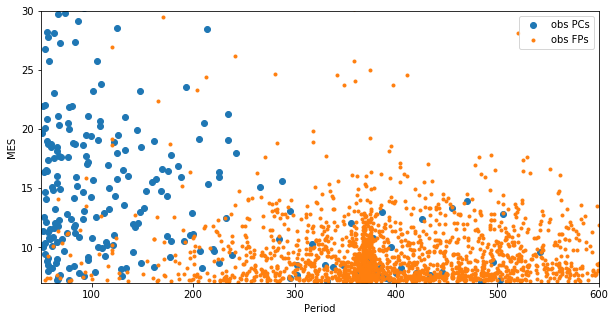

In [14]:
plt.figure(figsize=(10,5));
# plt.subplot(2,2,1);
plt.plot(spObsPcs['period'], spObsPcs['MES'], "o",
        spObsFps['period'], spObsFps['MES'], ".");
plt.ylim(mesMin,mesMax);
plt.xlim(periodMin,periodMax);
plt.legend(("obs PCs", "obs FPs"));
plt.ylabel('MES');
plt.xlabel('Period');


Bin the data so we have n TCEs and c FPs in each bin.

In [15]:

dPeriod = 20; 
dMes = 1;

p0 = periodMin;
pEnd = periodMax;
m0 = mesMin;
mEnd = mesMax;

# make the period-mes grid
NPeriod = int((pEnd - p0)/dPeriod);
NMes = int((mEnd - m0)/dMes);
cellPeriod = np.zeros((NPeriod,NMes));
cellMes = np.zeros((NPeriod,NMes));
obsTceGrid = np.zeros((NPeriod,NMes));
obsFpGrid = np.zeros((NPeriod,NMes));
obsPcGrid = np.zeros((NPeriod,NMes));

# count how many points are in each cell
for p in range(NPeriod):
    for m in range(NMes):
        cellPeriod[(p,m)] = p0 + p*dPeriod;
        cellMes[(p,m)] = m0 + m*dMes;
        pointsInCell = np.where(
            (spObsTces['period'] > cellPeriod[(p,m)]) 
            & (spObsTces['period'] <= cellPeriod[(p,m)]+dPeriod) 
            & (spObsTces['MES'] > cellMes[(p,m)]) 
            & (spObsTces['MES'] <= cellMes[(p,m)]+dMes));
        obsTceGrid[(p,m)] = len(pointsInCell[0]);

        pointsInCell = np.where(
            (spObsPcs['period'] > cellPeriod[(p,m)]) 
            & (spObsPcs['period'] <= cellPeriod[(p,m)]+dPeriod) 
            & (spObsPcs['MES'] > cellMes[(p,m)]) 
            & (spObsPcs['MES'] <= cellMes[(p,m)]+dMes));
        obsPcGrid[(p,m)] = len(pointsInCell[0]);

        pointsInCell = np.where(
            (spObsFps['period'] > cellPeriod[(p,m)]) 
            & (spObsFps['period'] <= cellPeriod[(p,m)]+dPeriod) 
            & (spObsFps['MES'] > cellMes[(p,m)]) 
            & (spObsFps['MES'] <= cellMes[(p,m)]+dMes));
        obsFpGrid[(p,m)] = len(pointsInCell[0]);
        

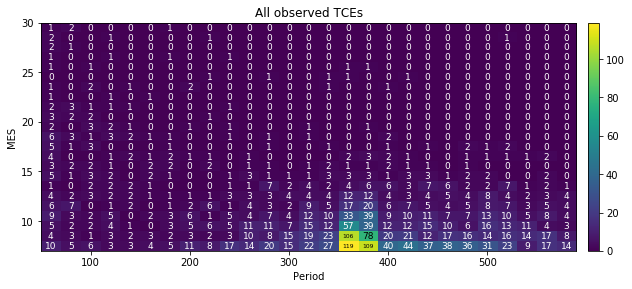

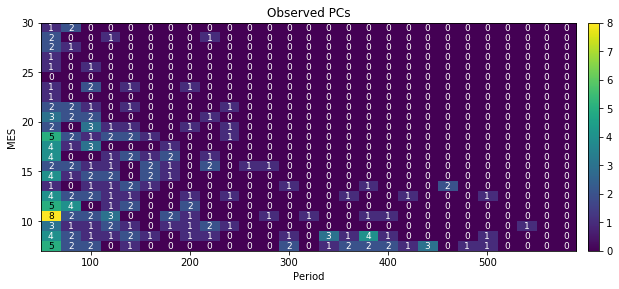

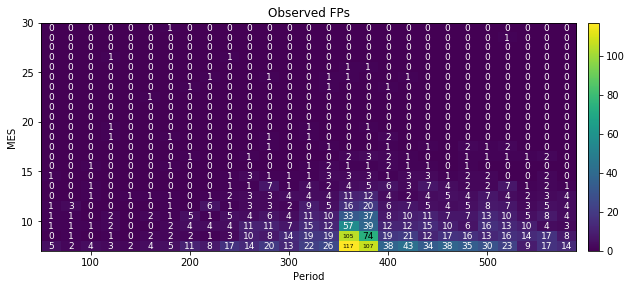

In [16]:
        
drawHeatMap(obsTceGrid, (10,10), cellPeriod, cellMes);           
plt.title("All observed TCEs");
plt.ylabel('MES');
plt.xlabel('Period');
drawHeatMap(obsPcGrid, (10,10), cellPeriod, cellMes);           
plt.title("Observed PCs");
plt.ylabel('MES');
plt.xlabel('Period');
drawHeatMap(obsFpGrid, (10,10), cellPeriod, cellMes);           
plt.title("Observed FPs");
plt.ylabel('MES');
plt.xlabel('Period');



Compute the PC and FC fractions in each cell to get a sense of what the fractions look like.  These are not used in the inference.

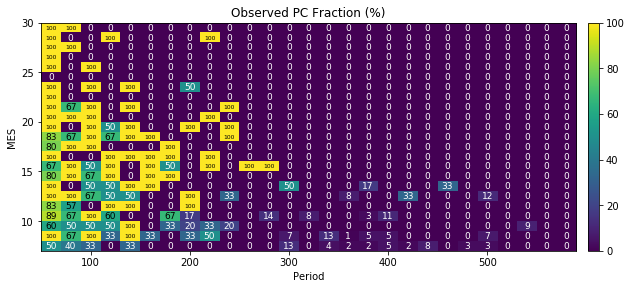

In [17]:
minTcePerCell = 0;

obsPcFrac = np.zeros(np.shape(obsTceGrid))
obsPcFrac[obsTceGrid>minTcePerCell] = obsPcGrid[obsTceGrid>minTcePerCell]/obsTceGrid[obsTceGrid>minTcePerCell];
drawHeatMap(np.round(100*obsPcFrac), (10,10), cellPeriod, cellMes);           
plt.title("Observed PC Fraction (%)");
plt.ylabel('MES');
plt.xlabel('Period');


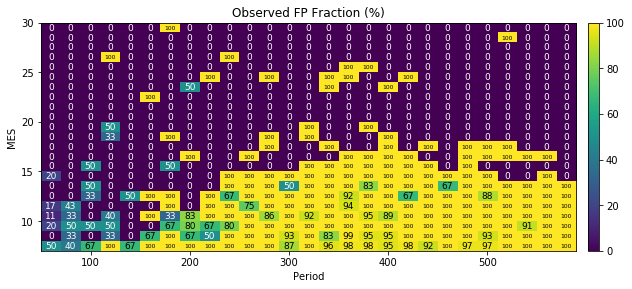

In [18]:
obsFpFrac = np.zeros(np.shape(obsTceGrid))
obsFpFrac[obsTceGrid>minTcePerCell] = obsFpGrid[obsTceGrid>minTcePerCell]/obsTceGrid[obsTceGrid>minTcePerCell];
drawHeatMap(np.round(100*obsFpFrac), (10,10), cellPeriod, cellMes);           
plt.title("Observed FP Fraction (%)");
plt.ylabel('MES');
plt.xlabel('Period');


Prepare the data for the call to emcee to do the Bayesian inference.

In [19]:
import dr25Models as funcModels

In [20]:

cObsFp = obsFpGrid.flatten();
nObsTce = obsTceGrid.flatten();

# convert to homogeneous coordinates on unit square [0,1]
cellX, cellY = funcModels.normalizeRange(cellPeriod, cellMes, [periodMin, periodMax], [mesMin, mesMax]);
gridShape = np.shape(cellX);
dx = 1./gridShape[0];
dy = 1./gridShape[1];
print("gridShape = " + str(gridShape) + ", dx = " + str(dx) + ", dy = " + str(dy))

cellXFlat = cellX.flatten();
cellYFlat = cellY.flatten();

tceData = [cellXFlat, cellYFlat, nObsTce, cObsFp];


gridShape = (27, 23), dx = 0.037037037037, dy = 0.0434782608696


We're ready to compute a Bayesian inference of the success probability $r$:

$$p(r|c, n) \propto p(c|r, n) p(r).$$

But we're computing $r$ as a function of period $p$, MES $m$, and parameters $\theta$, $r(\theta, p, m)$. So our inference becomes 

$$p(\theta|c, n, p, m) \propto p(c|\theta, n, p, m) p(\theta).$$

Because each cell is independent, we linearize the array to a list of cells indexed by $k$.  Then the likelihood for each cell is

$$p(c_k|\theta, n_k, p_k, m_k) = \left( \begin{array}{c_k} n_k \\ c_k \end{array} \right) r(\theta, p_k , m_k )^{c_k} (1-r(\theta, p_k , m_k ))^{n_k-c_k}$$

Because the $N$ cells are independent, the likelihood for the collection of cells is

$$p(c|\theta, n, p, m) \equiv p(c_1, \ldots, c_N|\theta, n_1, \ldots, n_N, p_1, \ldots, p_N, m_1, \ldots, m_N) = \prod_k \left( \begin{array}{c_k} n_k \\ c_k \end{array} \right) r(\theta, p_k , m_k )^{c_k} (1-r(\theta, p_k , m_k ))^{n_k-c_k}.$$

The log-likelihood is then

$$\log p(c|\theta, n, p, m) = \sum_k \log \left(\left( \begin{array}{c_k} n_k \\ c_k \end{array} \right) r(\theta, p_k , m_k )^{c_k} (1-r(\theta, p_k , m_k ))^{n_k-c_k} \right)$$ 
$$= \sum_k \left[ \log \left(\begin{array}{c_k} n_k \\ c_k \end{array} \right) + c_k \log \left(r(\theta, p_k , m_k ) \right) + \left( n_k-c_k \right) \log(1-r(\theta, p_k , m_k )) \right] $$

Define the likelihood and prior functions.

In [21]:
def lnBinlike(theta, data, model):
    x, y, n, c = data
    r = funcModels.rateModel(x,y,theta,model);
    clnr = c*np.log(r);
    clnr[c==0] = 0;
    lpl = np.sum(np.log(spec.comb(n,c)) + clnr + (n-c)*np.log(1-r));
        
    return lpl

def lnBinprior(theta, data, model):
    x, y, n, c = data
    # print(theta)
    if model == "constant":
        if 0.0 <= theta[0] <= 1:
            return 1.0
    elif model == "linearX":
        if -5000.0 < theta[0] < 5000.0 and 0.0 < theta[1] < 1 \
        and np.min(funcModels.rateModel(x, y, theta, model)) >= 0 \
        and np.max(funcModels.rateModel(x, y, theta, model)) <= 1:
            return 1.0
    elif model == "linearXY":
        if -5000.0 < theta[0] < 5000.0 and -5000.0 < theta[1] < 5000.0 \
        and 0.0 < theta[2] < 1 \
        and np.min(funcModels.rateModel(x, y, theta, model)) >= 0 \
        and np.max(funcModels.rateModel(x, y, theta, model)) <= 1:
            return 1.0
    elif model == "gaussian":
        if 0.45 < theta[0] < 1 and 0 <= theta[1] < 0.5 \
        and 1e-2 < theta[2] < 10 and 1e-2 < theta[3] < 10 and -1 <= theta[4] <= 1 and 0 <= theta[5] <= 1 \
        and np.min(funcModels.rateModel(x, y, theta, model)) >= 0 \
        and np.max(funcModels.rateModel(x, y, theta, model)) <= 1:
            return 1.0
    elif model == "logisticX":
        if -1 < theta[0] < 2.0 \
        and 1e-4 < theta[1] < 1e4 and 0 < theta[2] < 1e6 and 0 < theta[3] < 1e6 \
        and np.min(funcModels.rateModel(x, y, theta, model)) >= 0 \
        and np.max(funcModels.rateModel(x, y, theta, model)) <= 1:
            return 1.0
    elif model == "logisticY":
        if -1 <= theta[0] <= 2 \
        and 1e-4 < theta[1] < 100 and 0 < theta[2] <= 0.1 and 0.9 < theta[3] <= 1 \
        and 0 < theta[2] + theta[3] <= 1 \
        and np.min(funcModels.rateModel(x, y, theta, model)) >= 0 \
        and np.max(funcModels.rateModel(x, y, theta, model)) <= 1:
            return 1.0
    elif model == "rotatedLogisticY":
        if -1 <= theta[0] <= 2 \
        and 1e-4 < theta[1] < 100 and -180 < theta[2] <= 180 \
        and 0 < theta[3] <= 0.2 and 0.8 < theta[4] <= 1 \
        and 0 < theta[3] + theta[4] <= 1 \
        and np.min(funcModels.rateModel(x, y, theta, model)) >= 0 \
        and np.max(funcModels.rateModel(x, y, theta, model)) <= 1:
            return 1.0
    elif model == "rotatedLogisticYXFixedLogisticY":
        if -1 <= theta[0] <= 2 \
        and 1e-4 < theta[1] < 100 and -180 < theta[2] <= 180 \
        and 0 < theta[3] <= 0.2 and 0.8 < theta[4] <= 1 \
        and 0 < theta[3] + theta[4] <= 1 \
        and np.min(funcModels.rateModel(x, y, theta, model)) >= 0 \
        and np.max(funcModels.rateModel(x, y, theta, model)) <= 1:
            return 1.0
    elif model == "rotatedLogisticYXLogisticY":
        if -1 <= theta[0] <= 2 and 1e-4 < theta[1] < 100 \
        and -1 <= theta[2] <= 2 and 1e-4 < theta[3] < 100 \
        and -180 < theta[4] <= 180 \
        and 0 < theta[5] <= 0.2 and 0.8 < theta[6] <= 1 \
        and 0 < theta[5] + theta[6] <= 1 \
        and np.min(funcModels.rateModel(x, y, theta, model)) >= 0 \
        and np.max(funcModels.rateModel(x, y, theta, model)) <= 1:
            return 1.0
    elif model == "logisticY2":
        if -1 <= theta[0] <= 2 \
        and 1e-4 < theta[1] < 1e4 and 0.1 < theta[2] <= 1000 and 0 < theta[3] <= 0.1 and 0.9 < theta[4] <= 1 \
        and np.min(funcModels.rateModel(x, y, theta, model)) >= 0 \
        and np.max(funcModels.rateModel(x, y, theta, model)) <= 1:
            return 1.0
    elif model == "logisticX0":
        if -1 <= theta[0] <= 2 \
        and 1e-4 < theta[1] < 1e4 and 0 < theta[2] < 1 \
        and np.min(funcModels.rateModel(x, y, theta, model)) >= 0 \
        and np.max(funcModels.rateModel(x, y, theta, model)) <= 1:
            return 1.0
    elif model == "logisticY0":
        if -1 <= theta[0] <= 2 \
        and 1e-4 < theta[1] < 1e4 and 0 < theta[2] <= 1 \
        and np.min(funcModels.rateModel(x, y, theta, model)) >= 0 \
        and np.max(funcModels.rateModel(x, y, theta, model)) <= 1:
            return 1.0
    elif model == "logisticY02":
        if -1 <= theta[0] <= 2 \
        and 1e-4 < theta[1] < 1e4 and 0.1 < theta[2] <= 1000 and 0 < theta[3] <= 1 \
        and np.min(funcModels.rateModel(x, y, theta, model)) >= 0 \
        and np.max(funcModels.rateModel(x, y, theta, model)) <= 1:
            return 1.0
    elif model == "logisticX0xlogisticY0":
        if 0 <= theta[0] <= 1e3 and 0 <= theta[1] <= 1e3 \
        and 1e-4 < theta[2] < 1e4 and 1e-4 < theta[3] < 1e4 \
        and 0 < theta[4] < 1 \
        and np.min(funcModels.rateModel(x, y, theta, model)) >= 0 \
        and np.max(funcModels.rateModel(x, y, theta, model)) <= 1:
            return 1.0
    elif model == "rotatedLogisticX0xlogisticY0":
        if -1 <= theta[0] <= 2 and -1 <= theta[1] <= 2 \
        and 1e-4 < theta[2] < 1e4 and 1e-4 < theta[3] < 1e4 \
        and -180 < theta[4] < 180 and -180 < theta[5] < 180 \
        and 0 < theta[6] < 1 \
        and np.min(funcModels.rateModel(x, y, theta, model)) >= 0 \
        and np.max(funcModels.rateModel(x, y, theta, model)) <= 1:
            return 1.0
    elif model == "rotatedLogisticX0":
        if -1 <= theta[0] <= 2 \
        and 1e-4 < theta[1] < 100 and 0 < theta[2] <= 1  and -180 < theta[3] < 180 \
        and np.min(funcModels.rateModel(x, y, theta, model)) >= 0 \
        and np.max(funcModels.rateModel(x, y, theta, model)) <= 1:
            return 1.0
    elif model == "rotatedLogisticX02":
        if -1 <= theta[0] <= 2 \
        and 1e-4 < theta[1] < 1000 and 0.1 < theta[2] <= 1000 and 0 < theta[3] <= 1  and -180 < theta[4] < 180 \
        and np.min(funcModels.rateModel(x, y, theta, model)) >= 0 \
        and np.max(funcModels.rateModel(x, y, theta, model)) <= 1:
            return 1.0
    elif model == "rotatedLogisticX0xlogisticY02":
        if 0 <= theta[0] <= 2 and 0 <= theta[1] <= 2 \
        and 1e-4 < theta[2] < 1e4 and 1e-4 < theta[3] < 1e4 \
        and 0.01 < theta[4] < 1000 and 0.01 < theta[5] < 1000 \
        and -180 < theta[6] < 180 and -180 < theta[7] < 180 \
        and 0 < theta[8] < 1 \
        and np.min(funcModels.rateModel(x, y, theta, model)) >= 0 \
        and np.max(funcModels.rateModel(x, y, theta, model)) <= 1:
            return 1.0
    elif model == "rotatedLogisticX0+gaussian":
        if -1 <= theta[0] <= 2 \
        and 1e-4 < theta[1] < 100 and 0 < theta[2] <= 1  and -180 < theta[3] < 180 \
        and 0.45 < theta[4] < 1 and 0 <= theta[5] < 0.5 \
        and 1e-2 < theta[6] < 2 and 1e-2 < theta[7] < 2 and -1 <= theta[8] <= 0 \
        and np.min(funcModels.rateModel(x, y, theta, model)) >= 0 \
        and np.max(funcModels.rateModel(x, y, theta, model)) <= 1:
            return 1.0
    elif model == "dualBrokenPowerLaw":
        # print(funcModels.rateModel(x, y, theta, model))
        if 0 <= theta[0] <= 1 and 0 <= theta[1] <= 1 \
        and -2 < theta[2] < 2 and -2 < theta[3] < 2 and -2 < theta[4] < 2 and -2 < theta[5] < 2 \
        and 0 < theta[6] <= 1 \
        and np.min(funcModels.rateModel(x, y, theta, model)) >= 0 \
        and np.max(funcModels.rateModel(x, y, theta, model)) <= 1:
            return 1.0
    else:
        raise ValueError('Bad model name');
        
    # print(theta)
    return -np.inf

def lnBinprob(theta, data, model):
    x, y, n, c = data
    lp = lnBinprior(theta, data, model)
    # print("lnPoisprior = " + str(lp))
    if not np.isfinite(lp):
        return -np.inf
    # print(str(lnPoislike(theta, A, c)))
    return lp + lnBinlike(theta, data, model)



In [22]:

obsModel = "rotatedLogisticX0"

if obsModel == "constant":
    initialPos = funcModels.initRateModel(obsModel);
elif obsModel == "logisticY0":
    initialPos = funcModels.initRateModel(obsModel);
elif obsModel == "logisticY":
    initialPos = [-2.63785585e-02,  20,  0.02,  0.98];
elif obsModel == "rotatedLogisticY":
    initialPos = [  0.04944521,  23.31556305, -25.49590252,   0.04268818,   0.95325393];
elif obsModel == "rotatedLogisticYXLogisticY":
    initialPos = [  0.04944521,  23.31556305, -2.63785585e-02,  20,  -25.49590252,   0.04268818,   0.95325393];
elif obsModel == "logisticY02":
    initialPos = [-1.73396324e-01,  10,  2,  9.90011008e-01];
elif obsModel == "gaussian":
    initialPos = [ 0.62, 0.04,  1,  1, -0.01,  9.91039169e-01]
elif obsModel == "dualBrokenPowerLaw":
    initialPos = [ 0.56591357,  0.16586711,  1.9865538,  -0.00202982,  0.0262327,  -1.79204403, 0.98610129]
elif obsModel == "rotatedLogisticX0":
    initialPos = [ 1.2,  9.7715652,    0.99773284, -161.15051182];
elif obsModel == "rotatedLogisticX02":
    initialPos = [   0.45632181,   76.52125481,   24.82236241,    0.98233125, -161.15051182];
elif obsModel == "rotatedLogisticX0xlogisticY02":
    initialPos = [   1.6,    0.54208962,   45.93529004,   76.21697177,  527.33411115, 24.66179214,  -80, -108.48517773,    0.98293829];
elif obsModel == "rotatedLogisticX0+gaussian":
    initialPos = [ 8.09244005e-01,  7.72091689e+00,  9.96798125e-01, -1.70021035e+02,
        7.02672475e-01,  3.57238891e-01,  3.62755815e-01,  7.28225533e-02,
       -1.60673700e-01];
elif obsModel == "rotatedLogisticX0xlogisticY0":
    initialPos = [ 2e+00,  1.99824393e-01,  10,  7.70912734e+00, 9.24636388e-02, -1.00316033e+02,  9.95651001e-01]
else:
    initialPos = funcModels.initRateModel(obsModel);

print(initialPos)



[1.2, 9.7715652, 0.99773284, -161.15051182]


In [23]:
import scipy.optimize as op
nll = lambda *args: -lnBinlike(*args)
result = op.minimize(nll, initialPos, args=(tceData, obsModel))
maxLikelihoodResult = result["x"];
modelLabels = funcModels.getModelLabels(obsModel)
for i in range(0,len(maxLikelihoodResult)):
    print("maximum Likelihood " + modelLabels[i] + ":={:.3f}".format(maxLikelihoodResult[i]))
    
if lnBinprior(maxLikelihoodResult, tceData, obsModel) == -np.inf:
    maxLikelihoodResult = initialPos;
    print("violates prior, replacing maxLikelihoodResult result with initialPos")
    
x, y, n, c = tceData
r = funcModels.rateModel(x,y,maxLikelihoodResult,obsModel);
print("maximum Likelihood rate min = {:.3f}".format(np.min(np.min(r))) + ", max = {:.3f}".format(np.max(np.max(r))))




maximum Likelihood $x_0$:=0.710
maximum Likelihood $k_x$:=21.799
maximum Likelihood $A$:=0.962
maximum Likelihood $\phi$:=-156.675
maximum Likelihood rate min = 0.000, max = 0.962


/Users/steve/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
/Users/steve/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in multiply
  after removing the cwd from sys.path.
/Users/steve/anaconda3/envs/py2/lib/python2.7/site-packages/scipy/optimize/optimize.py:663: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/steve/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log
  


Fit $F_{\mathrm{obsFP}}$.

MCMC $x_0$:=0.705+0.023-0.024
MCMC $k_x$:=13.420+1.216-1.120
MCMC $A$:=0.981+0.004-0.004
MCMC $\phi$:=-158.492+3.054-3.038
pcFitTheta = [   0.70491048   13.42000638    0.98084512 -158.49233216]


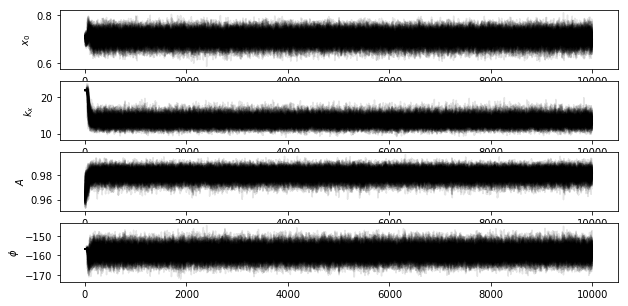

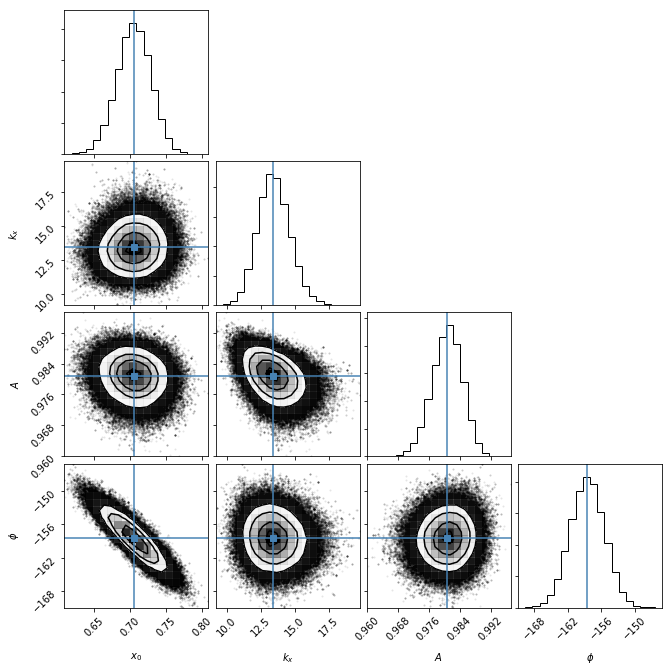

In [24]:
import emcee

ndim, nwalkers = len(maxLikelihoodResult), 100
pos = [maxLikelihoodResult + 1e-3*np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnBinprob, args=(tceData, obsModel))

sampler.run_mcmc(pos, 10000);

obsSamples = sampler.chain[:, 5000:, :].reshape((-1, ndim))
dataResult = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*np.percentile(obsSamples, [16, 50, 84],
                                                axis=0)))
dataResult = list(dataResult)

np.save("binObsPosteriors_" + str(obsModel) + ".npy", obsSamples)

modelLabels = funcModels.getModelLabels(obsModel)
for i in range(0,ndim):
    v = dataResult[i];    
    print("MCMC " + modelLabels[i] + ":={:.3f}".format(v[0]) + "+{:.3f}".format(v[1]) + "-{:.3f}".format(v[2]))
    # print("true " + modelLabels[i] + ":={:.3f}".format(trueTheta[i]))

resultSize = np.shape(dataResult);
fpFitTheta = np.zeros(resultSize[0]);
for i in range(resultSize[0]):
    fpFitTheta[i] = dataResult[i][0]
print("pcFitTheta = " + str(fpFitTheta))



plt.figure(figsize=(10,5))
for i in range(0,ndim):
    plt.subplot(ndim,1,i+1)
    plt.plot(np.transpose(sampler.chain[:, :, i]), color="k", alpha=0.1);
    plt.ylabel(modelLabels[i]);
    
import corner
# trueTheta = funcModels.initRateModel(model)
# fig = corner.corner(samples, labels=["$m$", "$b$", "$\ln\,f$"],
#                       truths=[m_true, b_true, np.log(f_true)])
fig = corner.corner(obsSamples, labels = modelLabels, truths = fpFitTheta)



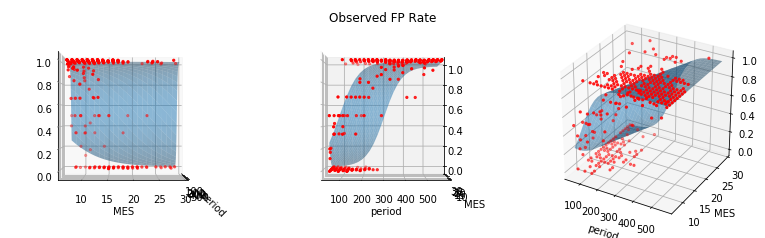

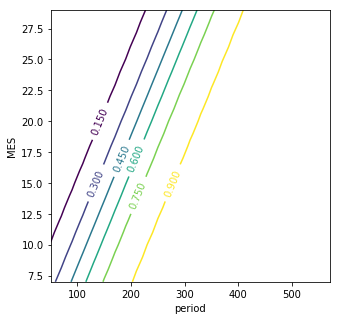

In [25]:
from mpl_toolkits.mplot3d import Axes3D  
from matplotlib import cm

fig = plt.figure(figsize=plt.figaspect(0.3));
ax = fig.add_subplot(1, 3, 1, projection='3d')
Z = funcModels.rateModel(cellX, cellY, fpFitTheta, obsModel);
surf = ax.plot_surface(cellPeriod, cellMes, Z, alpha = 0.5);
scat = ax.scatter(cellPeriod[obsTceGrid>0], cellMes[obsTceGrid>0], obsFpFrac[obsTceGrid>0], c='r', marker = '.');
plt.xlabel("period");
plt.ylabel("MES");
ax.view_init(0,0)

ax = fig.add_subplot(1, 3, 2, projection='3d')
surf = ax.plot_surface(cellPeriod, cellMes, Z, alpha = 0.5);
scat = ax.scatter(cellPeriod[obsTceGrid>0], cellMes[obsTceGrid>0], obsFpFrac[obsTceGrid>0], c='r', marker = '.');
plt.xlabel("period");
plt.ylabel("MES");
ax.view_init(0,-90)
plt.title("Observed FP Rate");

ax = fig.add_subplot(1, 3, 3, projection='3d')
surf = ax.plot_surface(cellPeriod, cellMes, Z, alpha = 0.5);
scat = ax.scatter(cellPeriod[obsTceGrid>0], cellMes[obsTceGrid>0], obsFpFrac[obsTceGrid>0], c='r', marker = '.');
plt.xlabel("period");
plt.ylabel("MES");

fig, ax = plt.subplots(figsize=(5,5));
CS = ax.contour(cellPeriod, cellMes, Z);
ax.clabel(CS, inline=1, fontsize=10);
plt.xlabel("period");
plt.ylabel("MES");



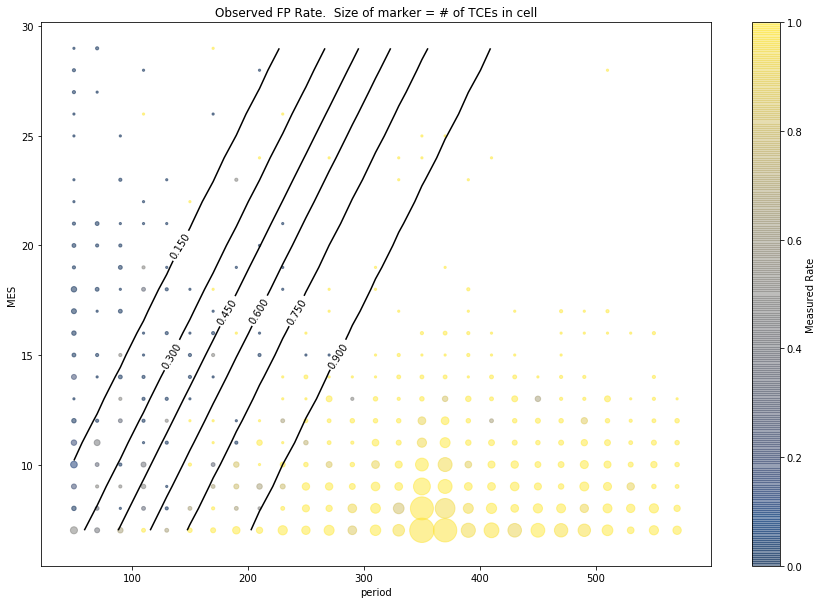

In [26]:
fig, ax = plt.subplots(figsize=(15,10));
Z = funcModels.rateModel(cellX, cellY, fpFitTheta, obsModel);
CS = ax.contour(cellPeriod, cellMes, Z, colors='k');
ax.clabel(CS, inline=1, fontsize=10);
scf = ax.scatter(cellPeriod[obsTceGrid>0], cellMes[obsTceGrid>0], cmap="cividis", c=obsFpFrac[obsTceGrid>0], s=5*obsTceGrid[obsTceGrid>0], alpha = 0.5);
plt.xlabel("period");
plt.ylabel("MES");
plt.title("Observed FP Rate.  Size of marker = # of TCEs in cell");
cbh = plt.colorbar(scf);
cbh.ax.set_ylabel("Measured Rate");


Reconstruct observed FP rates from the fit to compare with data.

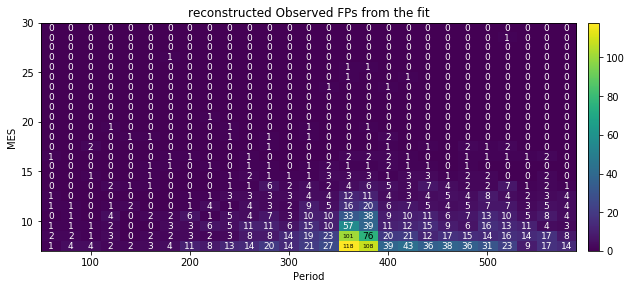

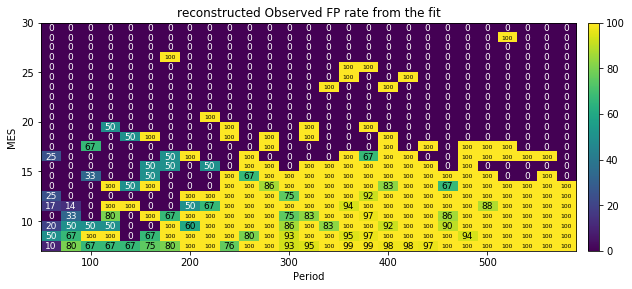

In [27]:
fitGrid = np.zeros(np.shape(obsTceGrid));

for p in range(NPeriod):
    for m in range(NMes):
        fitGrid[(p,m)] = np.random.binomial(obsTceGrid[(p,m)], 
            funcModels.rateModel(cellX[(p,m)]+dx/2, cellY[(p,m)]+dx/2, fpFitTheta, obsModel), 1);
        
drawHeatMap(fitGrid, (10,10), cellPeriod, cellMes);
plt.title('reconstructed Observed FPs from the fit');
plt.ylabel('MES');
plt.xlabel('Period');

fitFrac = np.zeros(np.shape(obsTceGrid))
fitFrac[obsTceGrid>minTcePerCell] = fitGrid[obsTceGrid>minTcePerCell]/obsTceGrid[obsTceGrid>minTcePerCell];
drawHeatMap(np.round(100*fitFrac), (10,10), cellPeriod, cellMes);           
plt.title('reconstructed Observed FP rate from the fit');
plt.ylabel('MES');
plt.xlabel('Period');




In [28]:
from ipywidgets import FloatProgress
from IPython.display import display

nFits = 1000;
fitGrid = np.zeros([np.shape(obsTceGrid)[0],np.shape(obsTceGrid)[1],nFits]);
sidx = [0]*nFits
progress = FloatProgress(min=0, max=nFits)
display(progress)


for f in range(nFits):
    sidx[f] = int(np.random.uniform(high=obsSamples.shape[0]-1));
    tTheta = obsSamples[sidx[f],:]

    for p in range(NPeriod):
        for m in range(NMes):
            rm = funcModels.rateModel(cellX[(p,m)]+dx/2, cellY[(p,m)]+dy/2, tTheta, obsModel)
            if rm > 1:
                rm = 1;
            fitGrid[(p,m,f)] = np.random.binomial(obsTceGrid[(p,m)], rm, 1);
    progress.value += 1
    
meanFit = np.mean(fitGrid, 2)
stdFit = np.std(fitGrid, 2)






FloatProgress(value=0.0, max=1000.0)

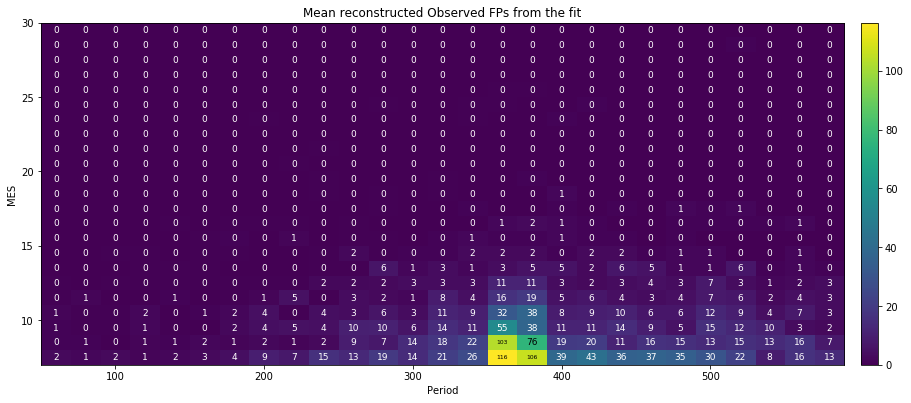

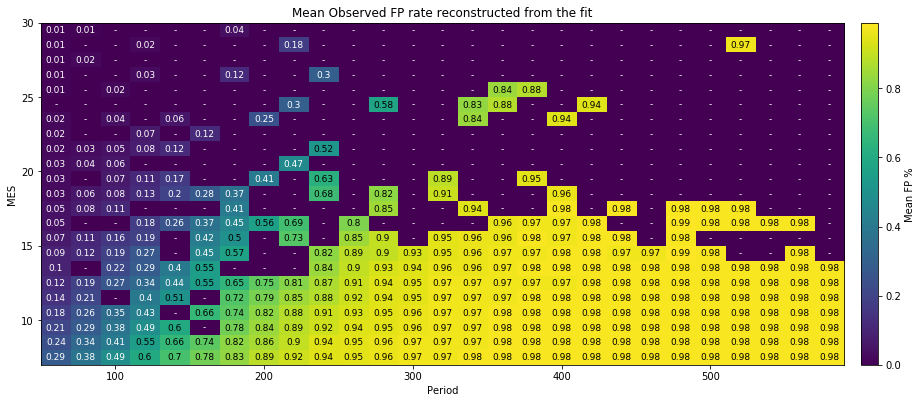

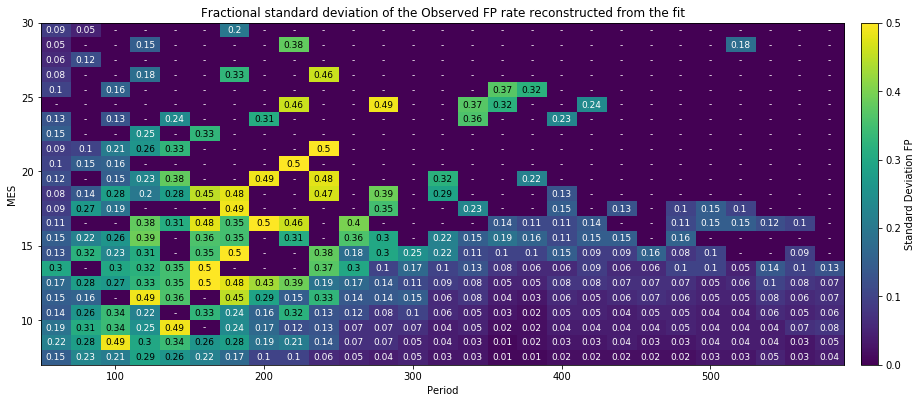

In [29]:
drawHeatMap(meanFit, (15,15), cellPeriod, cellMes);           
plt.title("Mean reconstructed Observed FPs from the fit");
plt.ylabel('MES');
plt.xlabel('Period');

fitFracMean = np.zeros(np.shape(obsTceGrid))
fitFracMean[obsTceGrid>minTcePerCell] = meanFit[obsTceGrid>minTcePerCell]/obsTceGrid[obsTceGrid>minTcePerCell];
drawHeatMap(np.round(fitFracMean, 2), (15,15), cellPeriod, cellMes, 
            nData = obsTceGrid, colorBarLabel="Mean FP %", forceInt=False);           
plt.ylabel('MES');
plt.xlabel('Period');
plt.savefig("obsFPMean.eps",bbox_inches='tight')
plt.title("Mean Observed FP rate reconstructed from the fit");

stdFrac = np.zeros(np.shape(obsTceGrid))
stdFrac[obsTceGrid>minTcePerCell] = stdFit[obsTceGrid>minTcePerCell]/obsTceGrid[obsTceGrid>minTcePerCell];
drawHeatMap(np.round(stdFrac, 2), (15,15), cellPeriod, cellMes, 
            nData = obsTceGrid, colorBarLabel="Standard Deviation FP", forceInt=False);           
plt.ylabel('MES');
plt.xlabel('Period');
plt.savefig("obsFPStd.eps",bbox_inches='tight')
plt.title("Fractional standard deviation of the Observed FP rate reconstructed from the fit");



-0.04870531744194722

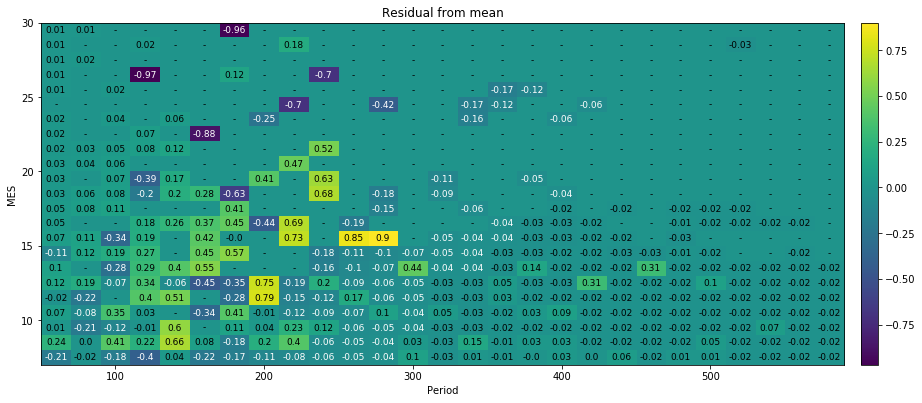

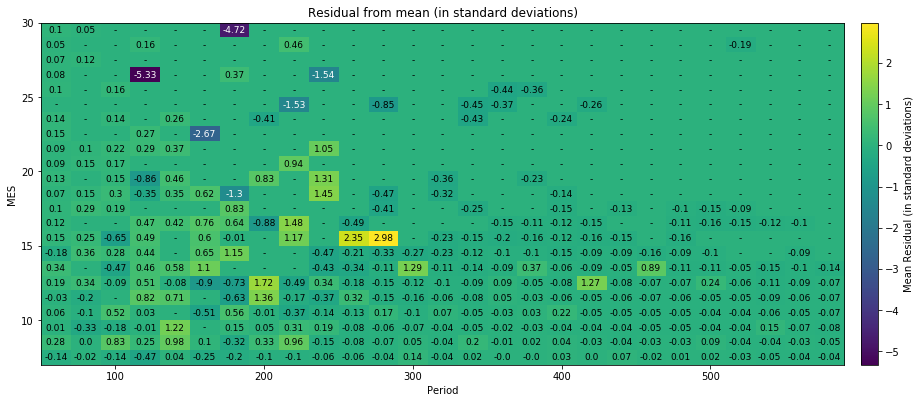

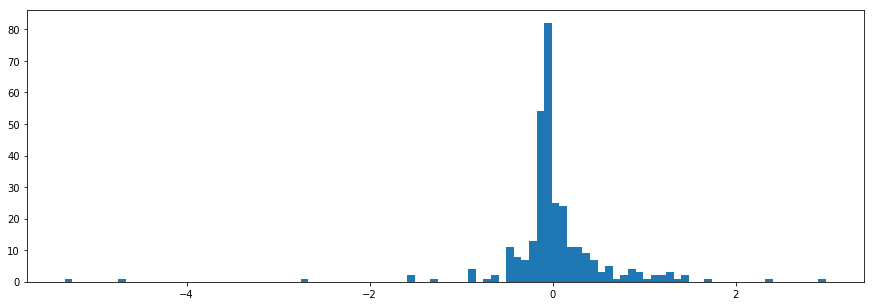

In [30]:
fitDiff = fitFracMean - obsFpFrac
fitDiffNorm =np.zeros(fitDiff.shape)
fitDiffNorm[stdFit>0] = fitDiff[stdFit>0]/stdFit[stdFit>0];

drawHeatMap(np.round(fitDiff, 2), (15,15), cellPeriod, cellMes, nData = obsTceGrid, forceInt = False);           
plt.title("Residual from mean");
plt.ylabel('MES');
plt.xlabel('Period');

drawHeatMap(np.round(fitDiffNorm, 2), (15,15), cellPeriod, cellMes, nData = obsTceGrid, 
            colorBarLabel="Mean Residual (in standard deviations)", forceInt = False); 
plt.ylabel('MES');
plt.xlabel('Period');
plt.savefig("obsFPMeanResid.eps",bbox_inches='tight')
plt.title("Residual from mean (in standard deviations)");

plt.figure(figsize=(15,5));
plt.hist(fitDiffNorm.flatten()[nObsTce > 0], 100);

np.median(fitDiffNorm.flatten()[nObsTce > 0])



In [31]:
aic = 2*len(fpFitTheta) - 2*lnBinlike(fpFitTheta, tceData, obsModel)
aic

382.4009770093219

In [32]:
maxLikelihoodAic = 2*len(maxLikelihoodResult) - 2*lnBinlike(maxLikelihoodResult, tceData, obsModel)
maxLikelihoodAic

424.91560335253985

In [33]:
fpFitTheta

array([   0.70491048,   13.42000638,    0.98084512, -158.49233216])

FloatProgress(value=0.0, max=500000.0)

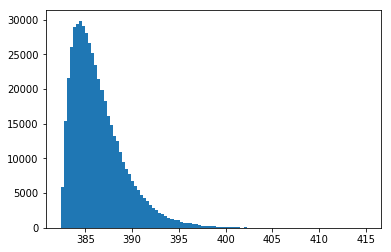

In [34]:
l = np.zeros(np.shape(obsSamples)[0])
aicDist = np.zeros(np.shape(obsSamples)[0])
progress = FloatProgress(min=0, max=obsSamples.shape[0])
display(progress)

for i in range(np.shape(obsSamples)[0]):
    l[i] = lnBinprob(obsSamples[i,:], tceData, obsModel)
    aicDist[i] = 2*len(obsSamples[i,:]) - 2*lnBinlike(obsSamples[i,:], tceData, obsModel)
    progress.value += 1
    
plt.hist(aicDist, 100);

In [35]:
min(aicDist)

382.39471614728296

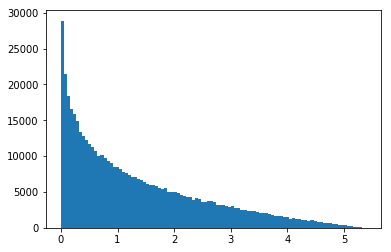

In [36]:
plt.hist(np.exp(l - np.median(l)), 100);

In [37]:
np.median(l)

-187.87922089915344

In [38]:
from skmonaco import mcquad

lbnds = np.empty([np.shape(obsSamples)[1]])
ubnds = np.empty([np.shape(obsSamples)[1]])
for i in range(len(lbnds)):
    lbnds[i] = np.min(obsSamples[:,i])
    ubnds[i] = np.max(obsSamples[:,i])

regularizationOffset = np.median(l)

def linBinProbInt(theta):
    return np.exp(lnBinprob(theta, tceData, obsModel) - regularizationOffset)

BF, BFerror = mcquad(linBinProbInt, xl=lbnds,xu=ubnds, npoints=1e7,nprocs=8 )
print("BF = {:.3e} +/- {:.3e}").format(BF,BFerror)

BF = 2.828e-02 +/- 8.822e-05


In [39]:
import os.path
import pickle

fname = "obsFpTable.pkl"
if os.path.isfile(fname):
    modelComparisonTable = pd.read_pickle(fname)
else:
    modelComparisonTable = pd.DataFrame({"Model": ["rotatedLogisticX0", "rotatedLogisticX0xlogisticY0", 
                                                  "dualBrokenPowerLaw", "rotatedLogisticX02", 
                                                   "rotatedLogisticX0xlogisticY02", "rotatedLogisticX0+gaussian"], 
                                        "medianMCMCAIC": [0., 0., 0., 0., 0., 0.],
                                        "maxLikelihoodAIC": [0., 0., 0., 0., 0., 0.],
                                        "MedianLogPost": [0., 0., 0., 0., 0., 0.],
                                        "IntegralPost": [0., 0., 0., 0., 0., 0.],
                                        "IntegralPostErr": [0., 0., 0., 0., 0., 0.],
                                        "medianMCMCTheta": [[0],[0],[0],[0],[0],[0]],
                                        "maxLikelihoodTheta": [[0],[0],[0],[0],[0],[0]],
                                        "periodRange": [[0],[0],[0],[0],[0],[0]],
                                        "mesRange": [[0],[0],[0],[0],[0],[0]]},
                                       columns=["Model","BayesFactor","BayesFactorError","AICRelativeProb","medianMCMCAIC","maxLikelihoodAIC","IntegralPost",
                                                "IntegralPostErr","MedianLogPost","medianMCMCTheta","maxLikelihoodTheta","periodRange","mesRange"])
    modelComparisonTable['IntegralPost'] = modelComparisonTable['IntegralPost'].map('{:,.3e}'.format)
    modelComparisonTable['IntegralPostErr'] = modelComparisonTable['IntegralPostErr'].map('{:,.3e}'.format)




In [40]:
mctIndex = np.where(modelComparisonTable["Model"].isin([obsModel]))[0][0]
print(mctIndex)
modelComparisonTable["medianMCMCAIC"][mctIndex] = aic;
modelComparisonTable["maxLikelihoodAIC"][mctIndex] = maxLikelihoodAic;
modelComparisonTable["MedianLogPost"][mctIndex] = regularizationOffset;
modelComparisonTable["IntegralPost"][mctIndex] = BF;
modelComparisonTable["IntegralPostErr"][mctIndex] = BFerror;
modelComparisonTable["medianMCMCTheta"][mctIndex] = fpFitTheta;
modelComparisonTable["maxLikelihoodTheta"][mctIndex] = maxLikelihoodResult;
modelComparisonTable["periodRange"][mctIndex] = [periodMin, periodMax];
modelComparisonTable["mesRange"][mctIndex] = [mesMin, mesMax];

0


/Users/steve/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/steve/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/steve/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexin

In [41]:
modelToCompareIndex = 0
modelComparisonTable["AICRelativeProb"] = 0.
minAic = np.min(modelComparisonTable["medianMCMCAIC"][modelToCompareIndex])

for i in range(len(modelComparisonTable)):
    modelComparisonTable["AICRelativeProb"].iloc[i] = np.exp((minAic - modelComparisonTable["medianMCMCAIC"].iloc[i])/2.)

/Users/steve/anaconda3/envs/py2/lib/python2.7/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [42]:
modelComparisonTable["BayesFactor"] = 0.
c1 = modelComparisonTable["MedianLogPost"].iloc[modelToCompareIndex]
i1 = np.double(modelComparisonTable["IntegralPost"].iloc[modelToCompareIndex])
for i in range(len(modelComparisonTable)):
    c2 = modelComparisonTable["MedianLogPost"].iloc[i]
    modelComparisonTable["BayesFactor"].iloc[i] = np.exp(c2 - c1)*np.double(modelComparisonTable["IntegralPost"].iloc[i])/i1

In [43]:
modelComparisonTable["BayesFactorError"] = 0.
B = np.double(modelComparisonTable["IntegralPost"].iloc[modelToCompareIndex])
sB = np.double(modelComparisonTable["IntegralPostErr"].iloc[modelToCompareIndex])
c1 = modelComparisonTable["MedianLogPost"].iloc[modelToCompareIndex]
for i in range(len(modelComparisonTable)):
    c2 = modelComparisonTable["MedianLogPost"].iloc[i]
    f = np.double(modelComparisonTable["BayesFactor"].iloc[i])
    A = np.exp(c2 - c1)*np.double(modelComparisonTable["IntegralPost"].iloc[i])
    sA = np.exp(c2 - c1)*np.double(modelComparisonTable["IntegralPostErr"].iloc[i])
    modelComparisonTable["BayesFactorError"].iloc[i] = f*np.sqrt((sA/A)**2 + (sB/B)**2)

/Users/steve/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


In [44]:
modelComparisonTable

,Model,BayesFactor,BayesFactorError,AICRelativeProb,medianMCMCAIC,maxLikelihoodAIC,IntegralPost,IntegralPostErr,MedianLogPost,medianMCMCTheta,maxLikelihoodTheta,periodRange,mesRange
0,rotatedLogisticX0,1.0,0.004411,1.000000e+00,382.400977,424.915603,0.0282835,8.82151e-05,-187.879221,"[0.7049104767818867, 13.420006379937993, 0.980...","[0.7095421241026307, 21.798529787926032, 0.961...","[50, 600]","[7, 30]"
1,rotatedLogisticX0xlogisticY0,0.0,NaN,1.089725e+83,0.000000,0.000000,0.000e+00,0.000e+00,0.000000,[0],[0],[0],[0]
2,dualBrokenPowerLaw,0.0,NaN,1.089725e+83,0.000000,0.000000,0.000e+00,0.000e+00,0.000000,[0],[0],[0],[0]
3,rotatedLogisticX02,0.0,NaN,1.089725e+83,0.000000,0.000000,0.000e+00,0.000e+00,0.000000,[0],[0],[0],[0]
4,rotatedLogisticX0xlogisticY02,0.0,NaN,1.089725e+83,0.000000,0.000000,0.000e+00,0.000e+00,0.000000,[0],[0],[0],[0]
5,rotatedLogisticX0+gaussian,0.0,NaN,1.089725e+83,0.000000,0.000000,0.000e+00,0.000e+00,0.000000,[0],[0],[0],[0]


In [45]:
modelComparisonTable.to_pickle(fname)

In [46]:
tt = pd.read_pickle(fname)

In [47]:
tt

,Model,BayesFactor,BayesFactorError,AICRelativeProb,medianMCMCAIC,maxLikelihoodAIC,IntegralPost,IntegralPostErr,MedianLogPost,medianMCMCTheta,maxLikelihoodTheta,periodRange,mesRange
0,rotatedLogisticX0,1.0,0.004411,1.000000e+00,382.400977,424.915603,0.0282835,8.82151e-05,-187.879221,"[0.7049104767818867, 13.420006379937993, 0.980...","[0.7095421241026307, 21.798529787926032, 0.961...","[50, 600]","[7, 30]"
1,rotatedLogisticX0xlogisticY0,0.0,NaN,1.089725e+83,0.000000,0.000000,0.000e+00,0.000e+00,0.000000,[0],[0],[0],[0]
2,dualBrokenPowerLaw,0.0,NaN,1.089725e+83,0.000000,0.000000,0.000e+00,0.000e+00,0.000000,[0],[0],[0],[0]
3,rotatedLogisticX02,0.0,NaN,1.089725e+83,0.000000,0.000000,0.000e+00,0.000e+00,0.000000,[0],[0],[0],[0]
4,rotatedLogisticX0xlogisticY02,0.0,NaN,1.089725e+83,0.000000,0.000000,0.000e+00,0.000e+00,0.000000,[0],[0],[0],[0]
5,rotatedLogisticX0+gaussian,0.0,NaN,1.089725e+83,0.000000,0.000000,0.000e+00,0.000e+00,0.000000,[0],[0],[0],[0]


In [48]:
%%javascript
IPython.notebook.save_notebook()

<IPython.core.display.Javascript object>

In [49]:
%%bash -s "$obsModel"
jupyter nbconvert --to html binomialObsFPRate.ipynb
mv binomialObsFPRate.html htmlArchive/binomialObsFPRate_$1.html

[NbConvertApp] Converting notebook binomialObsFPRate.ipynb to html
[NbConvertApp] Writing 1988058 bytes to binomialObsFPRate.html


In [50]:
kic[kic.kepid == 5809954]

,kepid,tm_designation,teff,teff_err1,teff_err2,logg,logg_err1,logg_err2,feh,feh_err1,...,timeout06p0,timeout07p5,timeout09p0,timeout10p5,timeout12p0,timeout12p5,timeout15p0,timeoutsumry,cdppslplong,cdppslpshrt
